In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from tqdm import tqdm
from tools_ryu import mytool

In [3]:
mktcap = pd.read_pickle("mktcap_pp.pickle")
price = pd.read_pickle("close_pp.pickle").replace(0, np.nan)

daily_rtn = price.pct_change(fill_method=None)

mktcap_mask = (mktcap > 1_000_000).replace({True:1,
                                            False:np.nan})
mktcap_screened = (mktcap * mktcap_mask)
weight = mktcap_screened.apply(lambda x: x / np.nansum(x), axis=1)

Cross-Sectional-Momentum : Weekly Rebalancing

In [4]:
weekly_mktcap = mktcap_screened.resample("W").last()
weekly_rtn = price.pct_change(7,fill_method=None) \
                  .resample("W").last()
weekly_price = price.resample("W").last()

In [5]:
# Momentum 그룹을 구하기 위해서 필요함
weekly_rtn_pp = weekly_rtn * np.sign(weekly_mktcap)

In [6]:
# 언제부터 시작하는 지 찾자 (최소 100개의 코인이 필요)
cnt = weekly_rtn_pp.count(1)
more100 = cnt.loc[cnt > 99] # 여기서 start date가 나온다
start = more100.index[0]
more100

date
2017-04-09     124
2017-04-16     128
2017-04-23     136
2017-04-30     145
2017-05-07     123
              ... 
2023-03-19    1517
2023-03-26    1514
2023-04-02    1519
2023-04-09    1511
2023-04-16    1529
Freq: W-SUN, Length: 315, dtype: int64

In [7]:
weekly_rtn_sample_pp = weekly_rtn_pp.loc[start:]
weekly_mktcap_sample = weekly_mktcap.loc[start:]
weekly_price_sample = weekly_price.loc[start:]

In [8]:
# rank를 계산해줍니다
rank = weekly_rtn_sample_pp.rank(axis=1, method="first")

# rank가 존재하는 코인의 수를 구합니다
coin_count = rank.count(axis=1)

# 그룹별로 동일한 코인 수를 포함하기 위해 각 그룹의 rank thresh를 생성해줍니다
rank_thresh = coin_count.apply(lambda x: [i for i in range(0,x, x//5)])

t1 = rank_thresh.apply(lambda x: x[1])
t2 = rank_thresh.apply(lambda x: x[2])
t3 = rank_thresh.apply(lambda x: x[3])
t4 = rank_thresh.apply(lambda x: x[4])

rank_thresh

date
2017-04-09          [0, 24, 48, 72, 96, 120]
2017-04-16         [0, 25, 50, 75, 100, 125]
2017-04-23         [0, 27, 54, 81, 108, 135]
2017-04-30              [0, 29, 58, 87, 116]
2017-05-07          [0, 24, 48, 72, 96, 120]
                           ...              
2023-03-19    [0, 303, 606, 909, 1212, 1515]
2023-03-26    [0, 302, 604, 906, 1208, 1510]
2023-04-02    [0, 303, 606, 909, 1212, 1515]
2023-04-09    [0, 302, 604, 906, 1208, 1510]
2023-04-16    [0, 305, 610, 915, 1220, 1525]
Freq: W-SUN, Length: 315, dtype: object

In [9]:
g1_mask = rank.apply(lambda x: x <= t1, axis=0) \
              .replace({True:1, False:np.nan})
g2_mask = rank.apply(lambda x: (t1 < x)&(x <= t2), axis=0) \
              .replace({True:1, False:np.nan})
g3_mask = rank.apply(lambda x: (t2 < x)&(x <= t3), axis=0) \
              .replace({True:1, False:np.nan})
g4_mask = rank.apply(lambda x: (t3 < x)&(x <= t4), axis=0) \
              .replace({True:1, False:np.nan})
g5_mask = rank.apply(lambda x: x > t4, axis=0) \
              .replace({True:1, False:np.nan})           

In [10]:
# 각 그룹별 weight를 생성
weight_g1 = (g1_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g2 = (g2_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g3 = (g3_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g4 = (g4_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g5 = (g5_mask * weekly_mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)

In [11]:
# 그룹별 코인 개수 출력 
concat = pd.concat([weight_g1.count(1), weight_g2.count(1),
                    weight_g3.count(1), weight_g4.count(1),
                    weight_g5.count(1)], axis=1)#.plot();

coin = pd.concat([concat, concat.sum(1)], axis=1)
coin.columns = [0,1,2,3,4,"Sum"]

coin

,0,1,2,3,4,Sum
date,,,,,,
2017-04-09,24,24,24,24,28,124
2017-04-16,25,25,25,25,28,128
2017-04-23,27,27,27,27,28,136
2017-04-30,29,29,29,29,29,145
2017-05-07,24,24,24,24,27,123
...,...,...,...,...,...,...
2023-03-19,303,303,303,303,305,1517
2023-03-26,302,302,302,302,306,1514
2023-04-02,303,303,303,303,307,1519


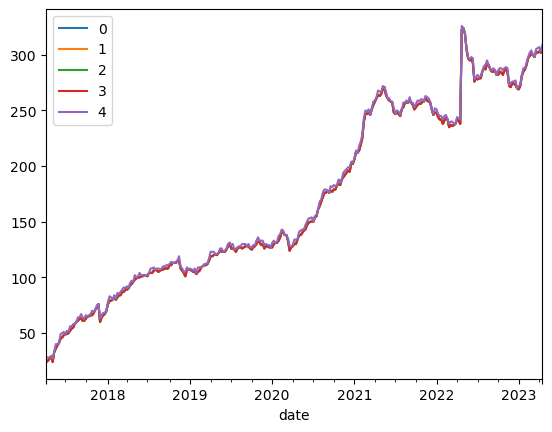

In [12]:
concat.plot();

In [13]:
# filter를 마켓켑과 리턴에 곱해줘서 각 그룹별 리턴 계산
rtn_g1 = (weekly_rtn.loc[start:] * weight_g1.shift(1))#.sum(1)
rtn_g2 = (weekly_rtn.loc[start:] * weight_g2.shift(1))#.sum(1)
rtn_g3 = (weekly_rtn.loc[start:] * weight_g3.shift(1))#.sum(1)
rtn_g4 = (weekly_rtn.loc[start:] * weight_g4.shift(1))#.sum(1)
rtn_g5 = (weekly_rtn.loc[start:] * weight_g5.shift(1))#.sum(1)

In [16]:
pf1 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g1, price, start)
pf2 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g2, price, start)
pf3 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g3, price, start)
pf4 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g4, price, start)
pf5 = mytool.change_weekly_to_daily(weekly_price, weekly_rtn, 
                             weight_g5, price, start)

rtn_dict = {"Q1":pf1,
            "Q2":pf2,
            "Q3":pf3,
            "Q4":pf4,
            "Q5":pf5}

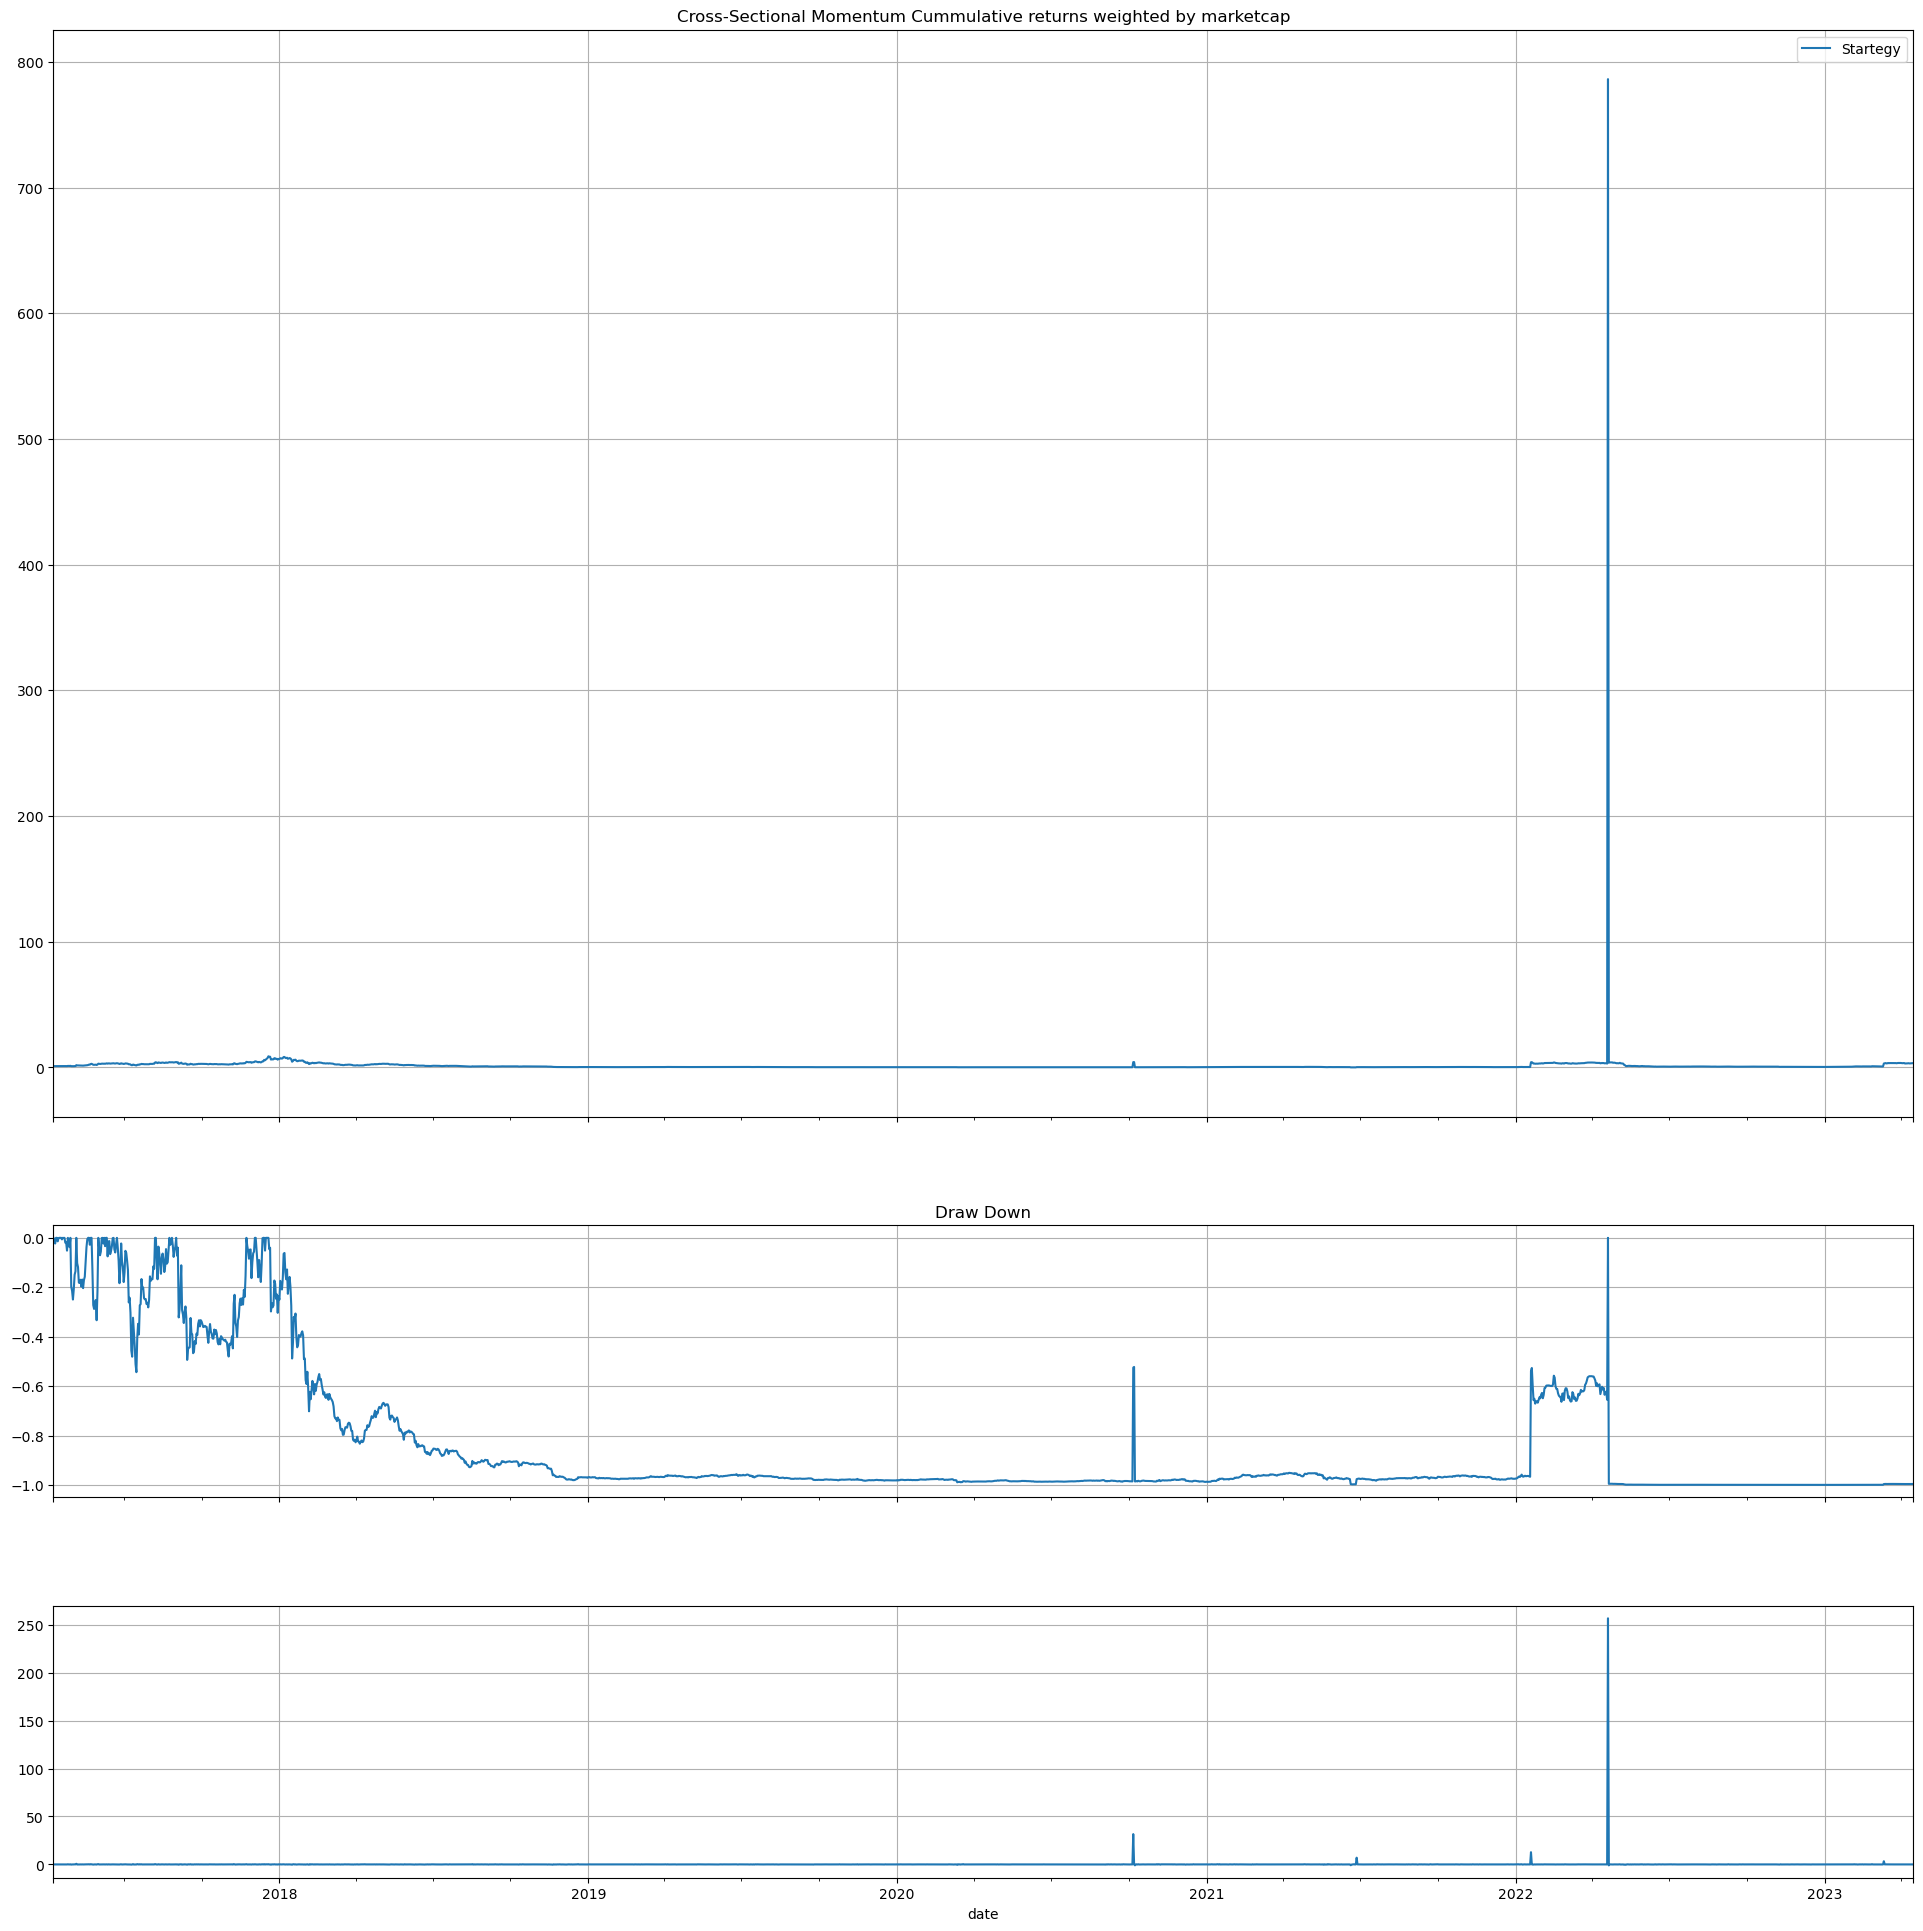

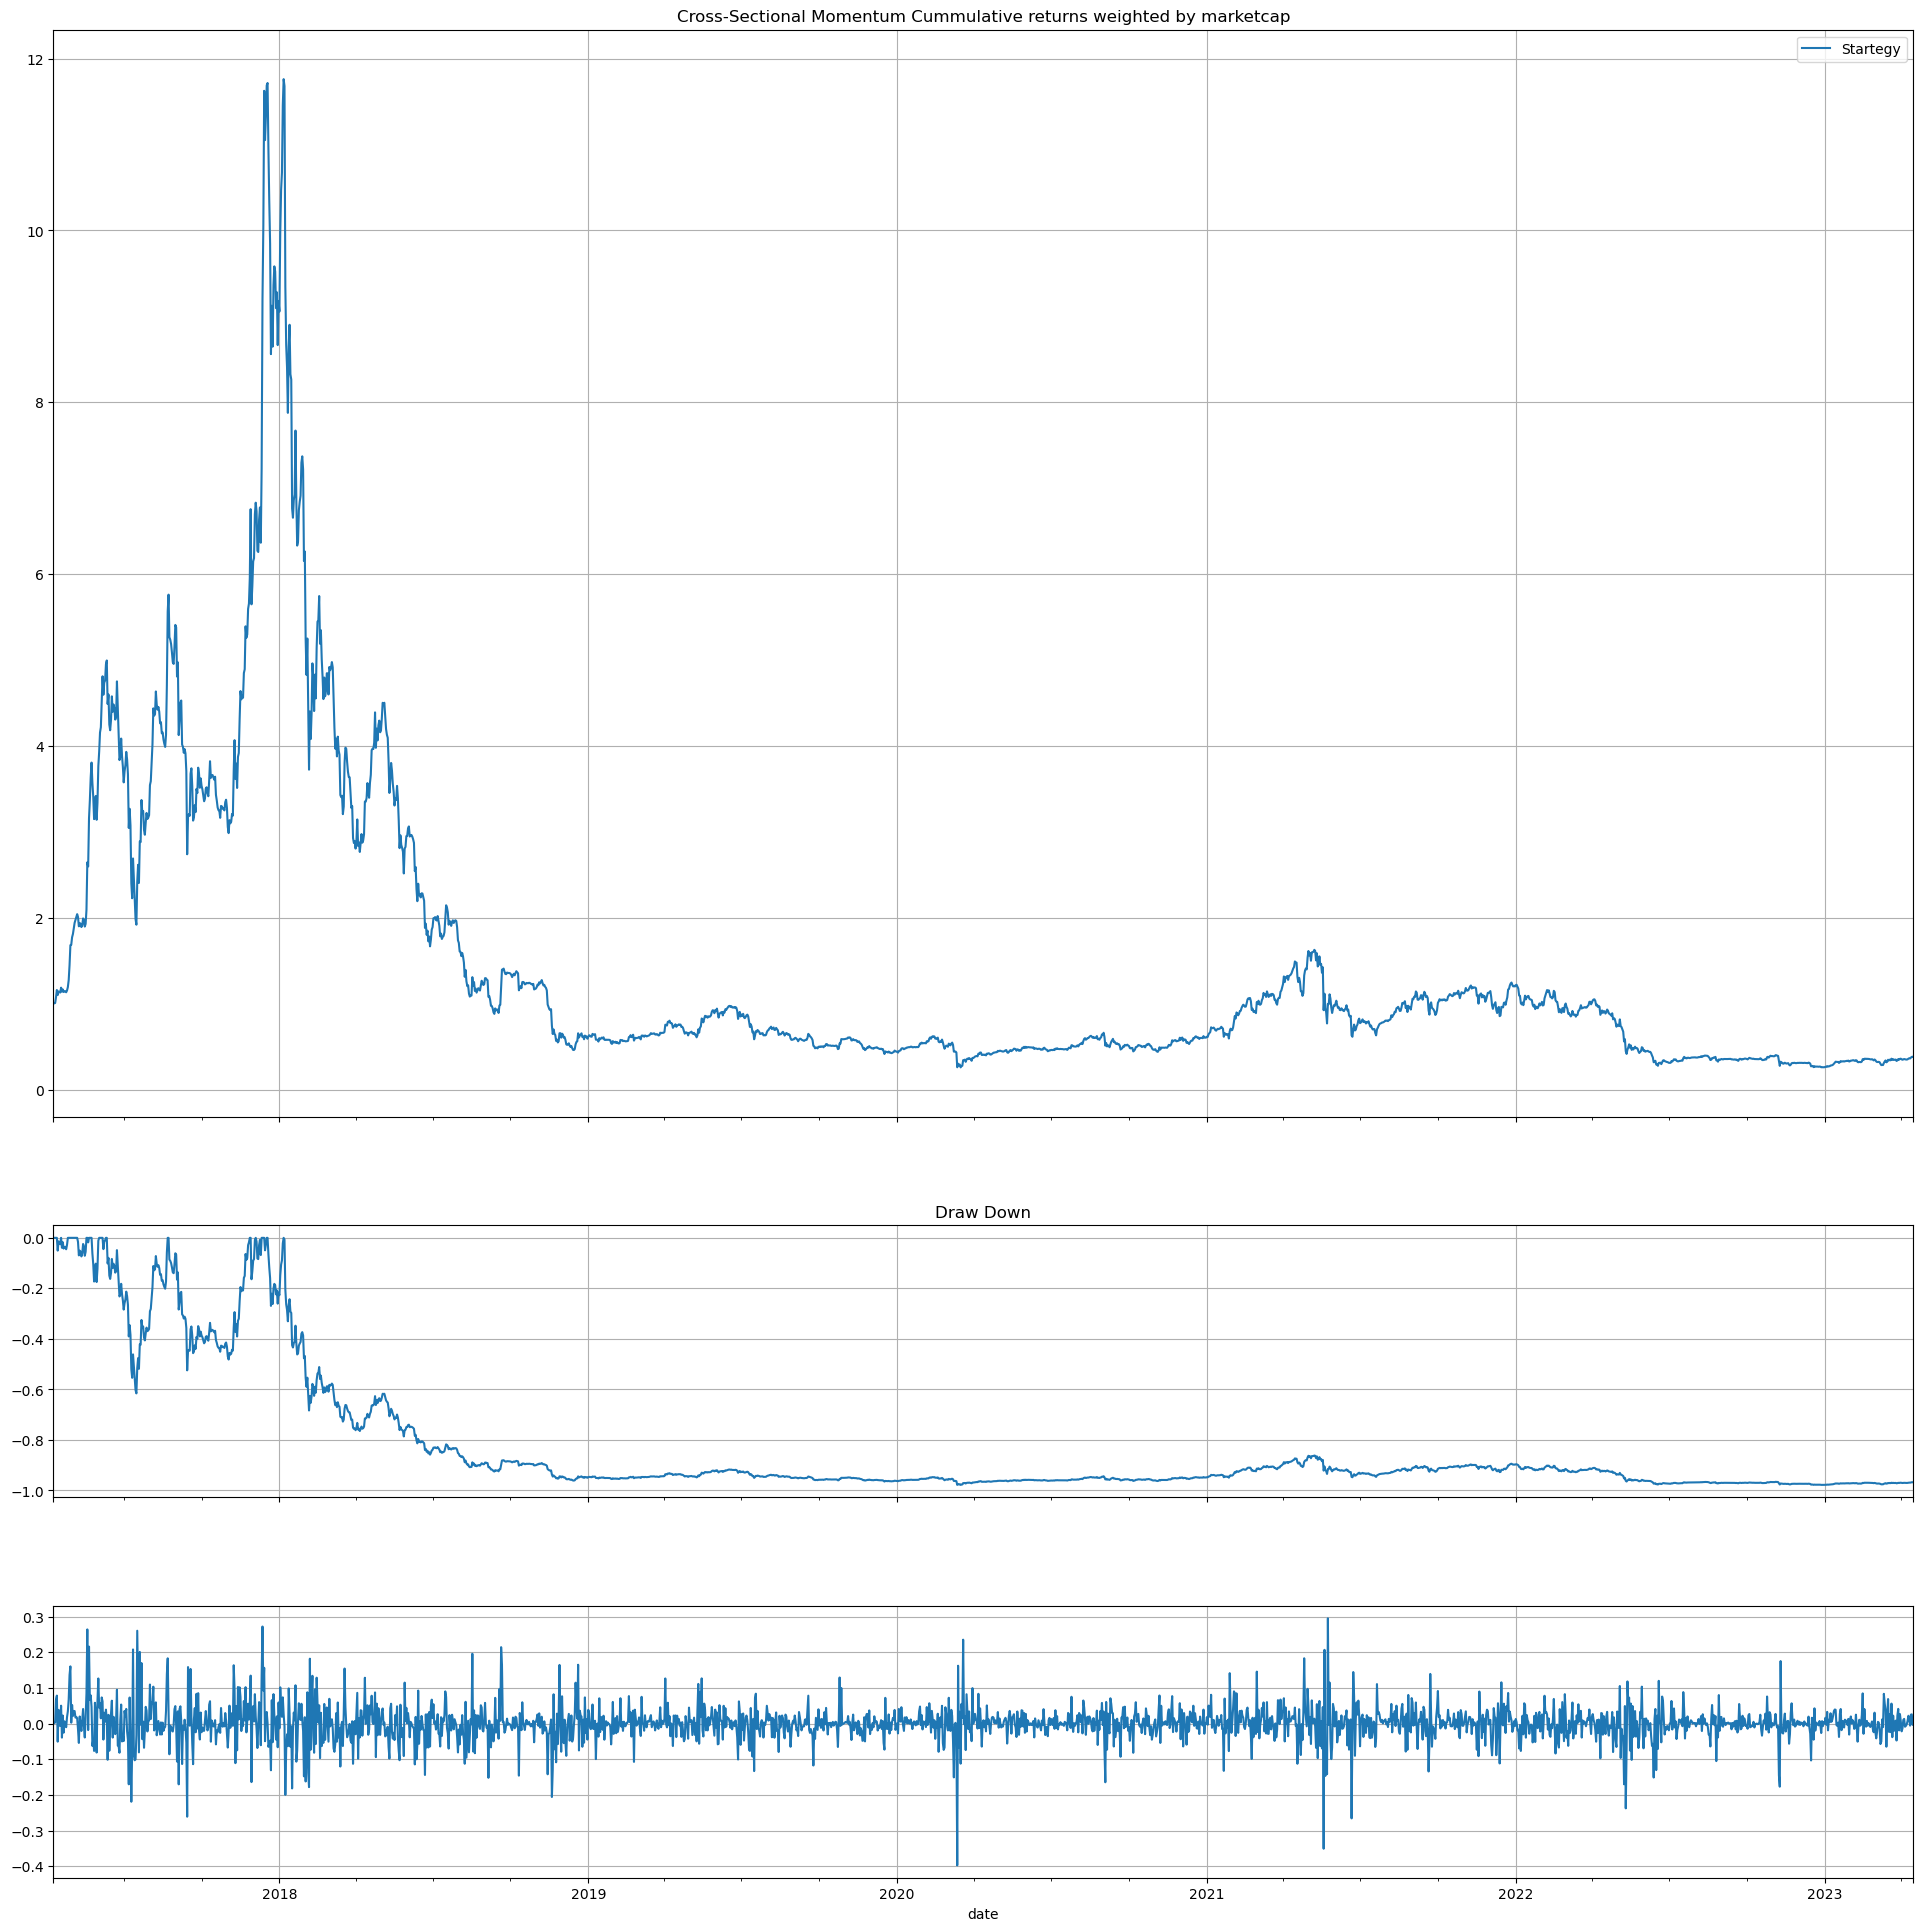

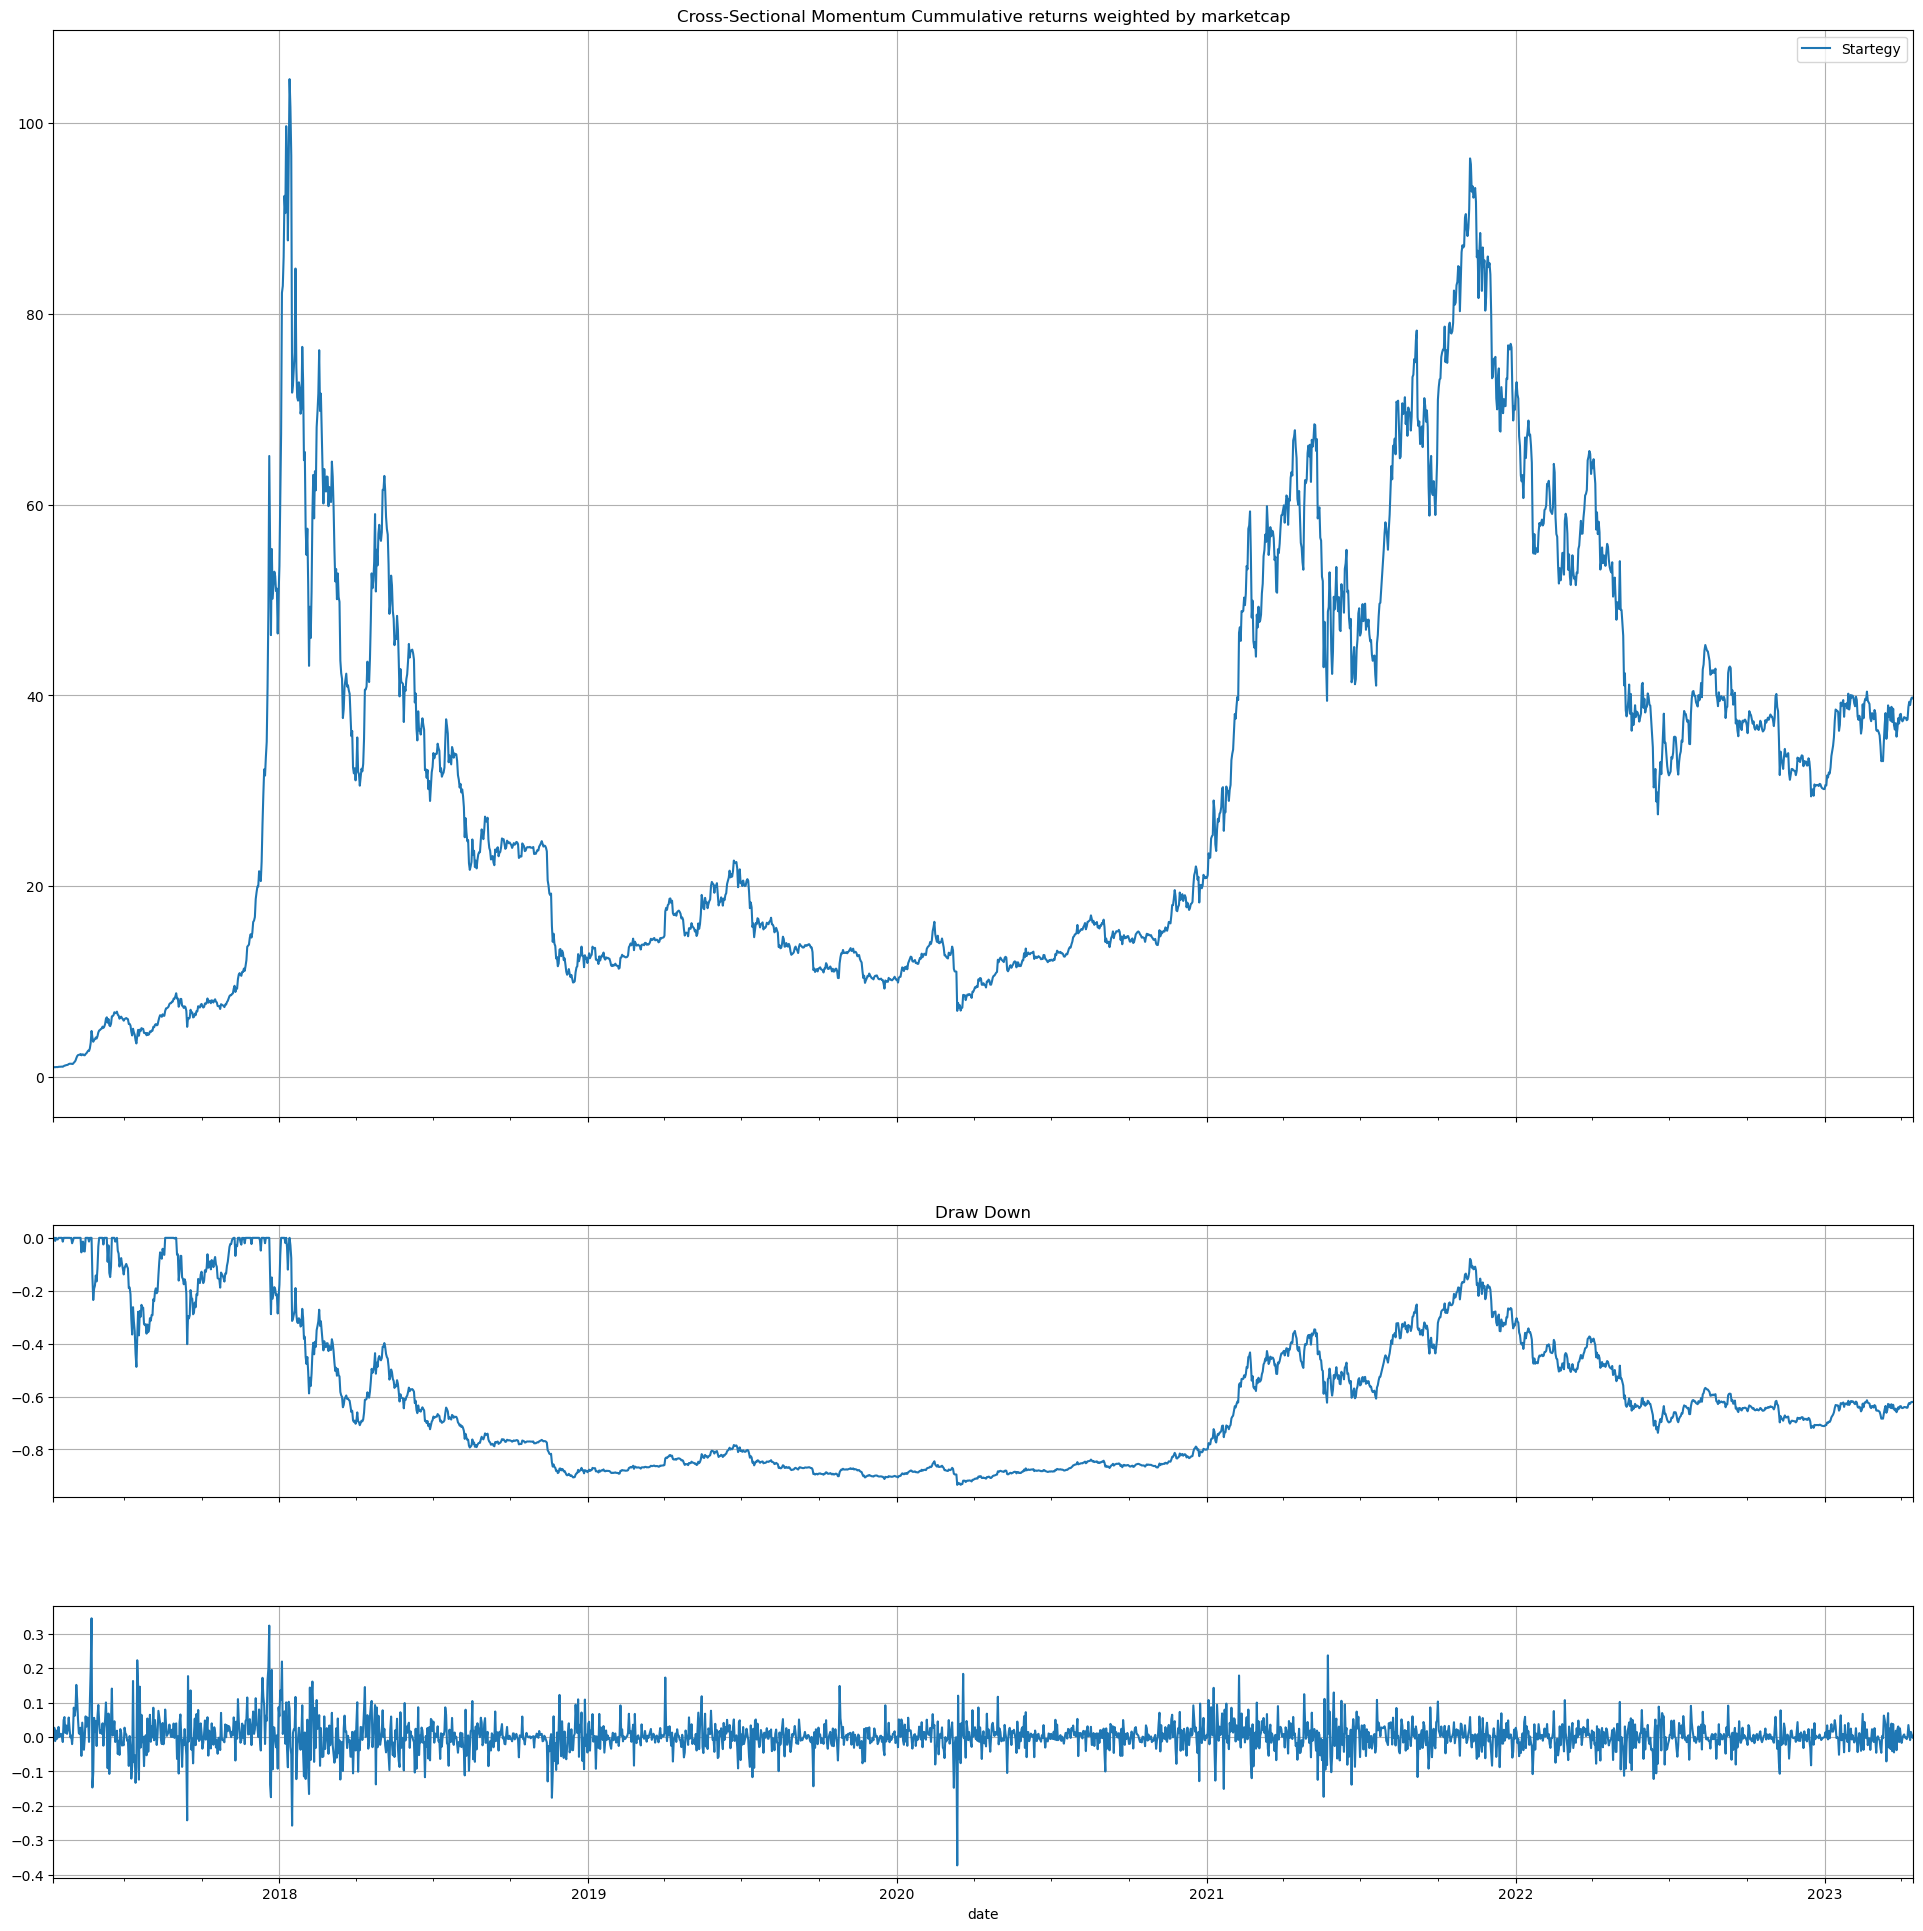

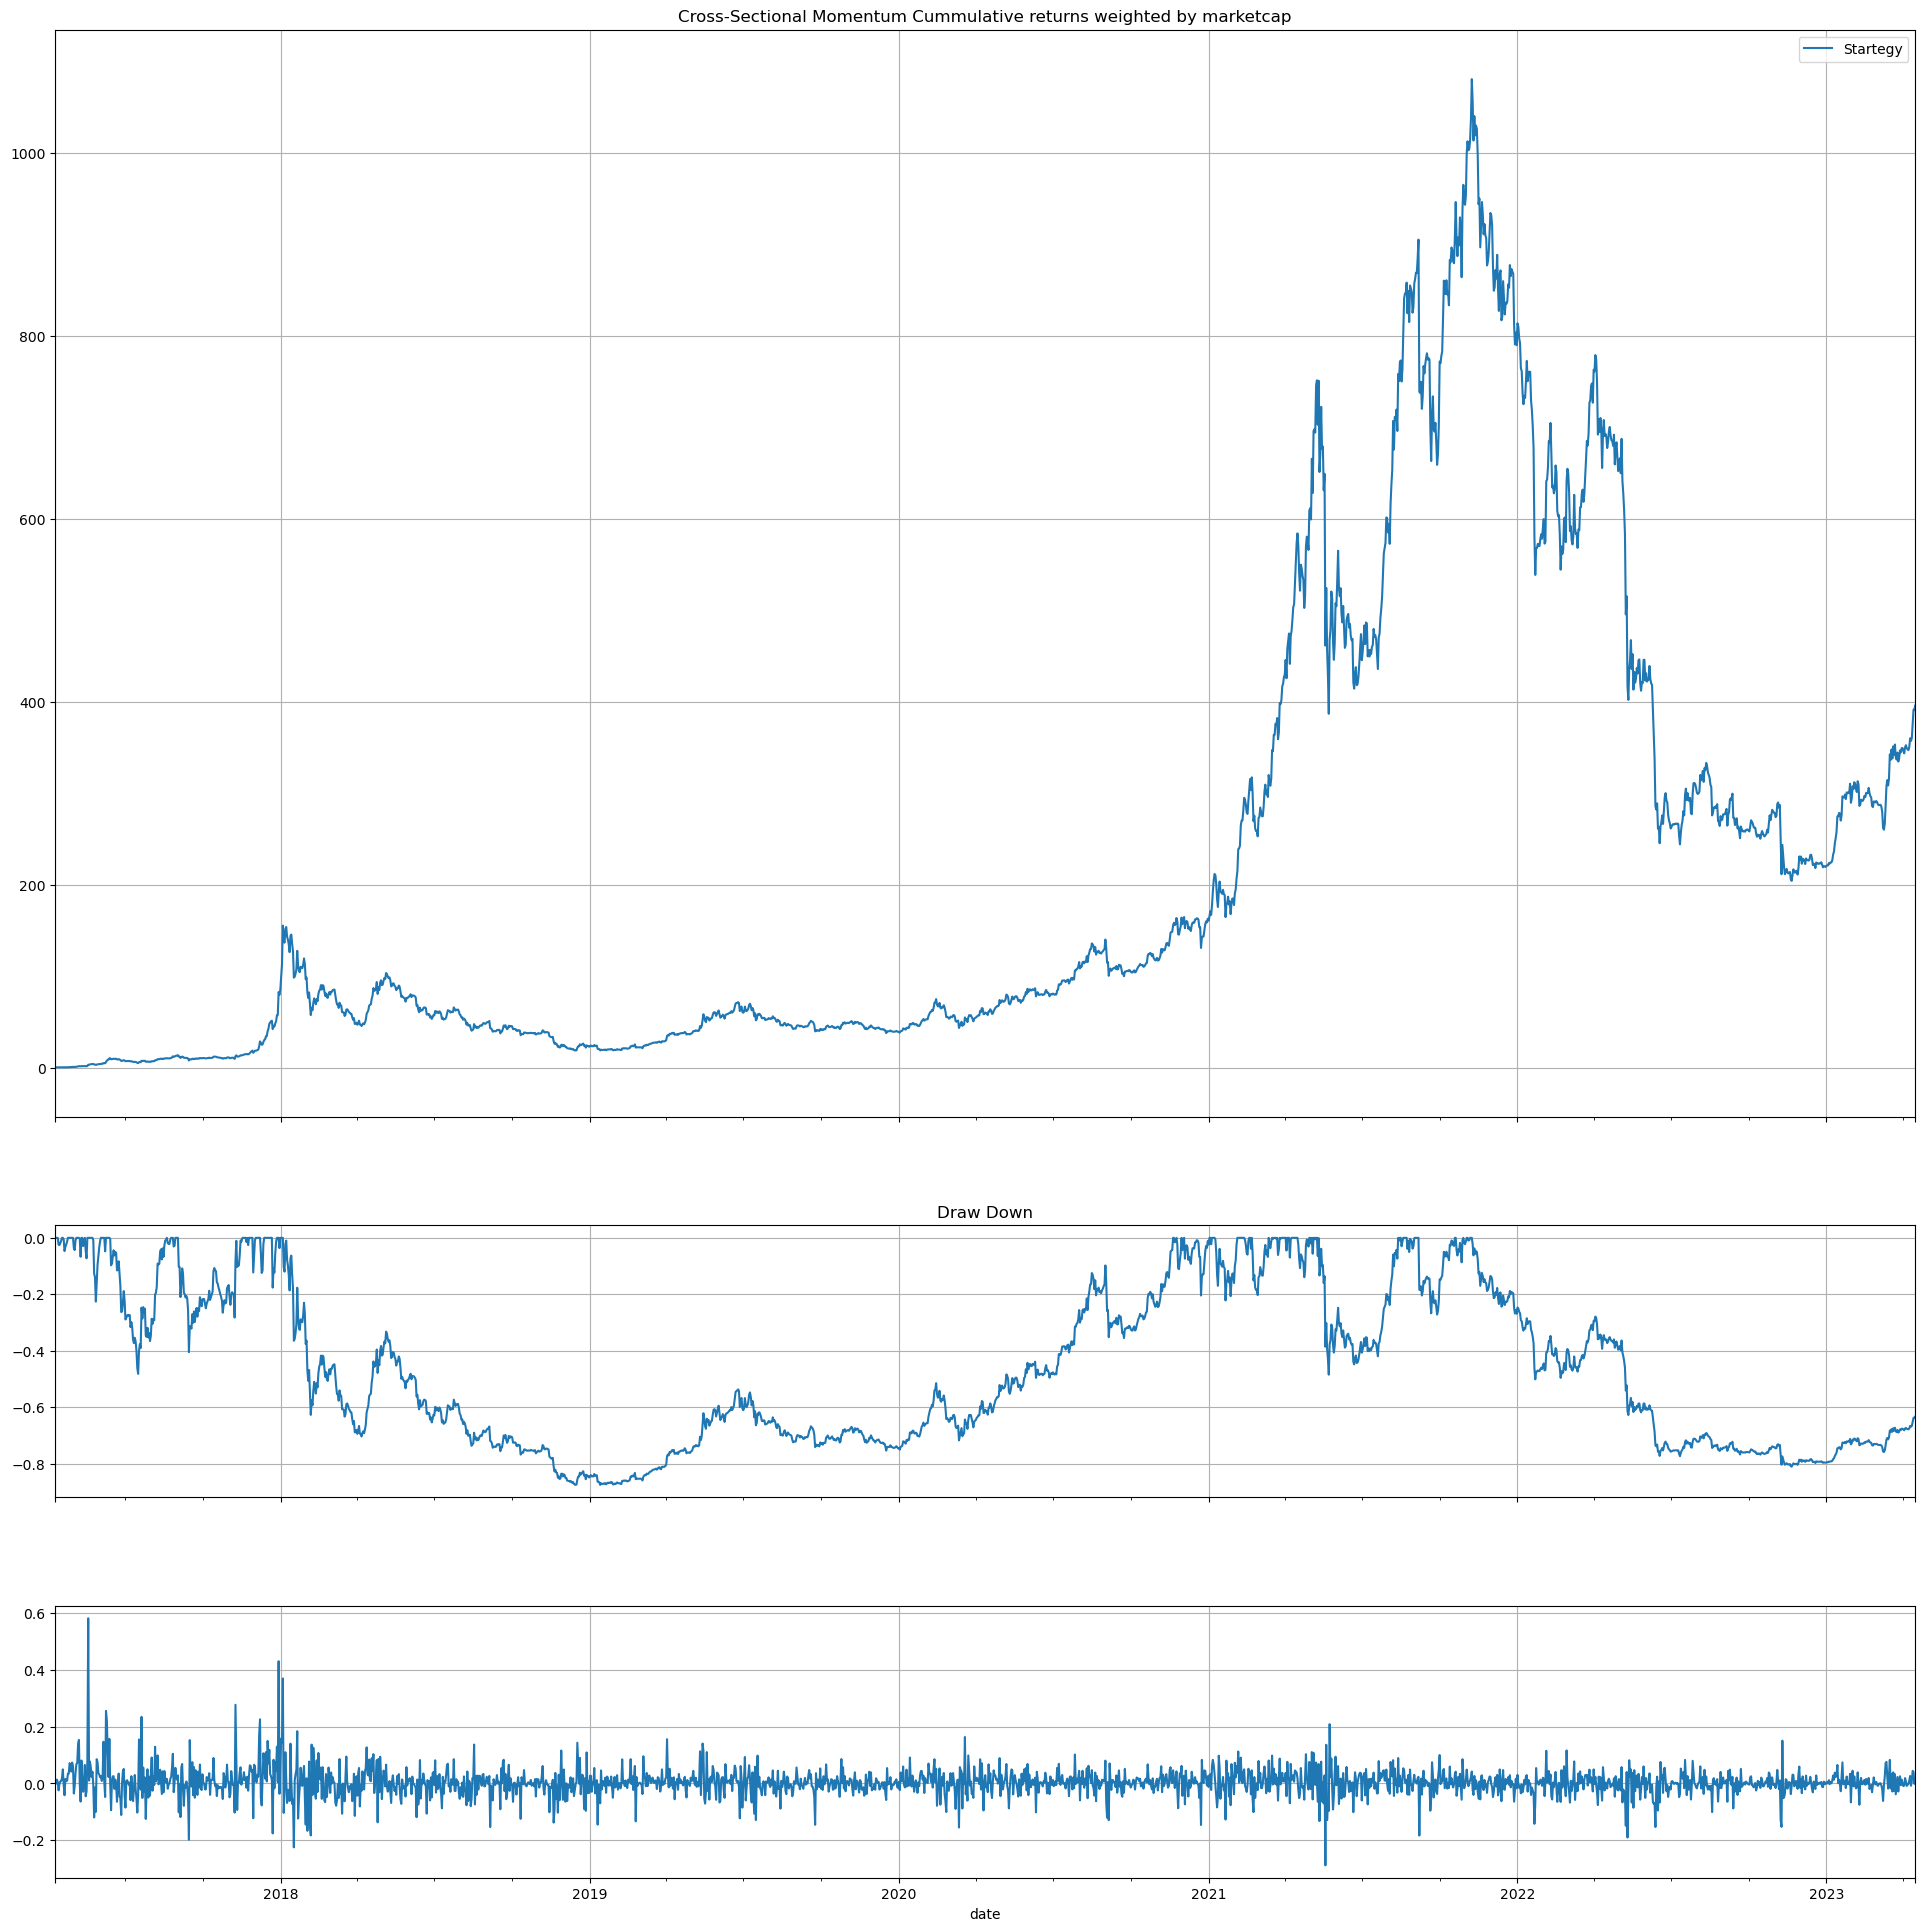

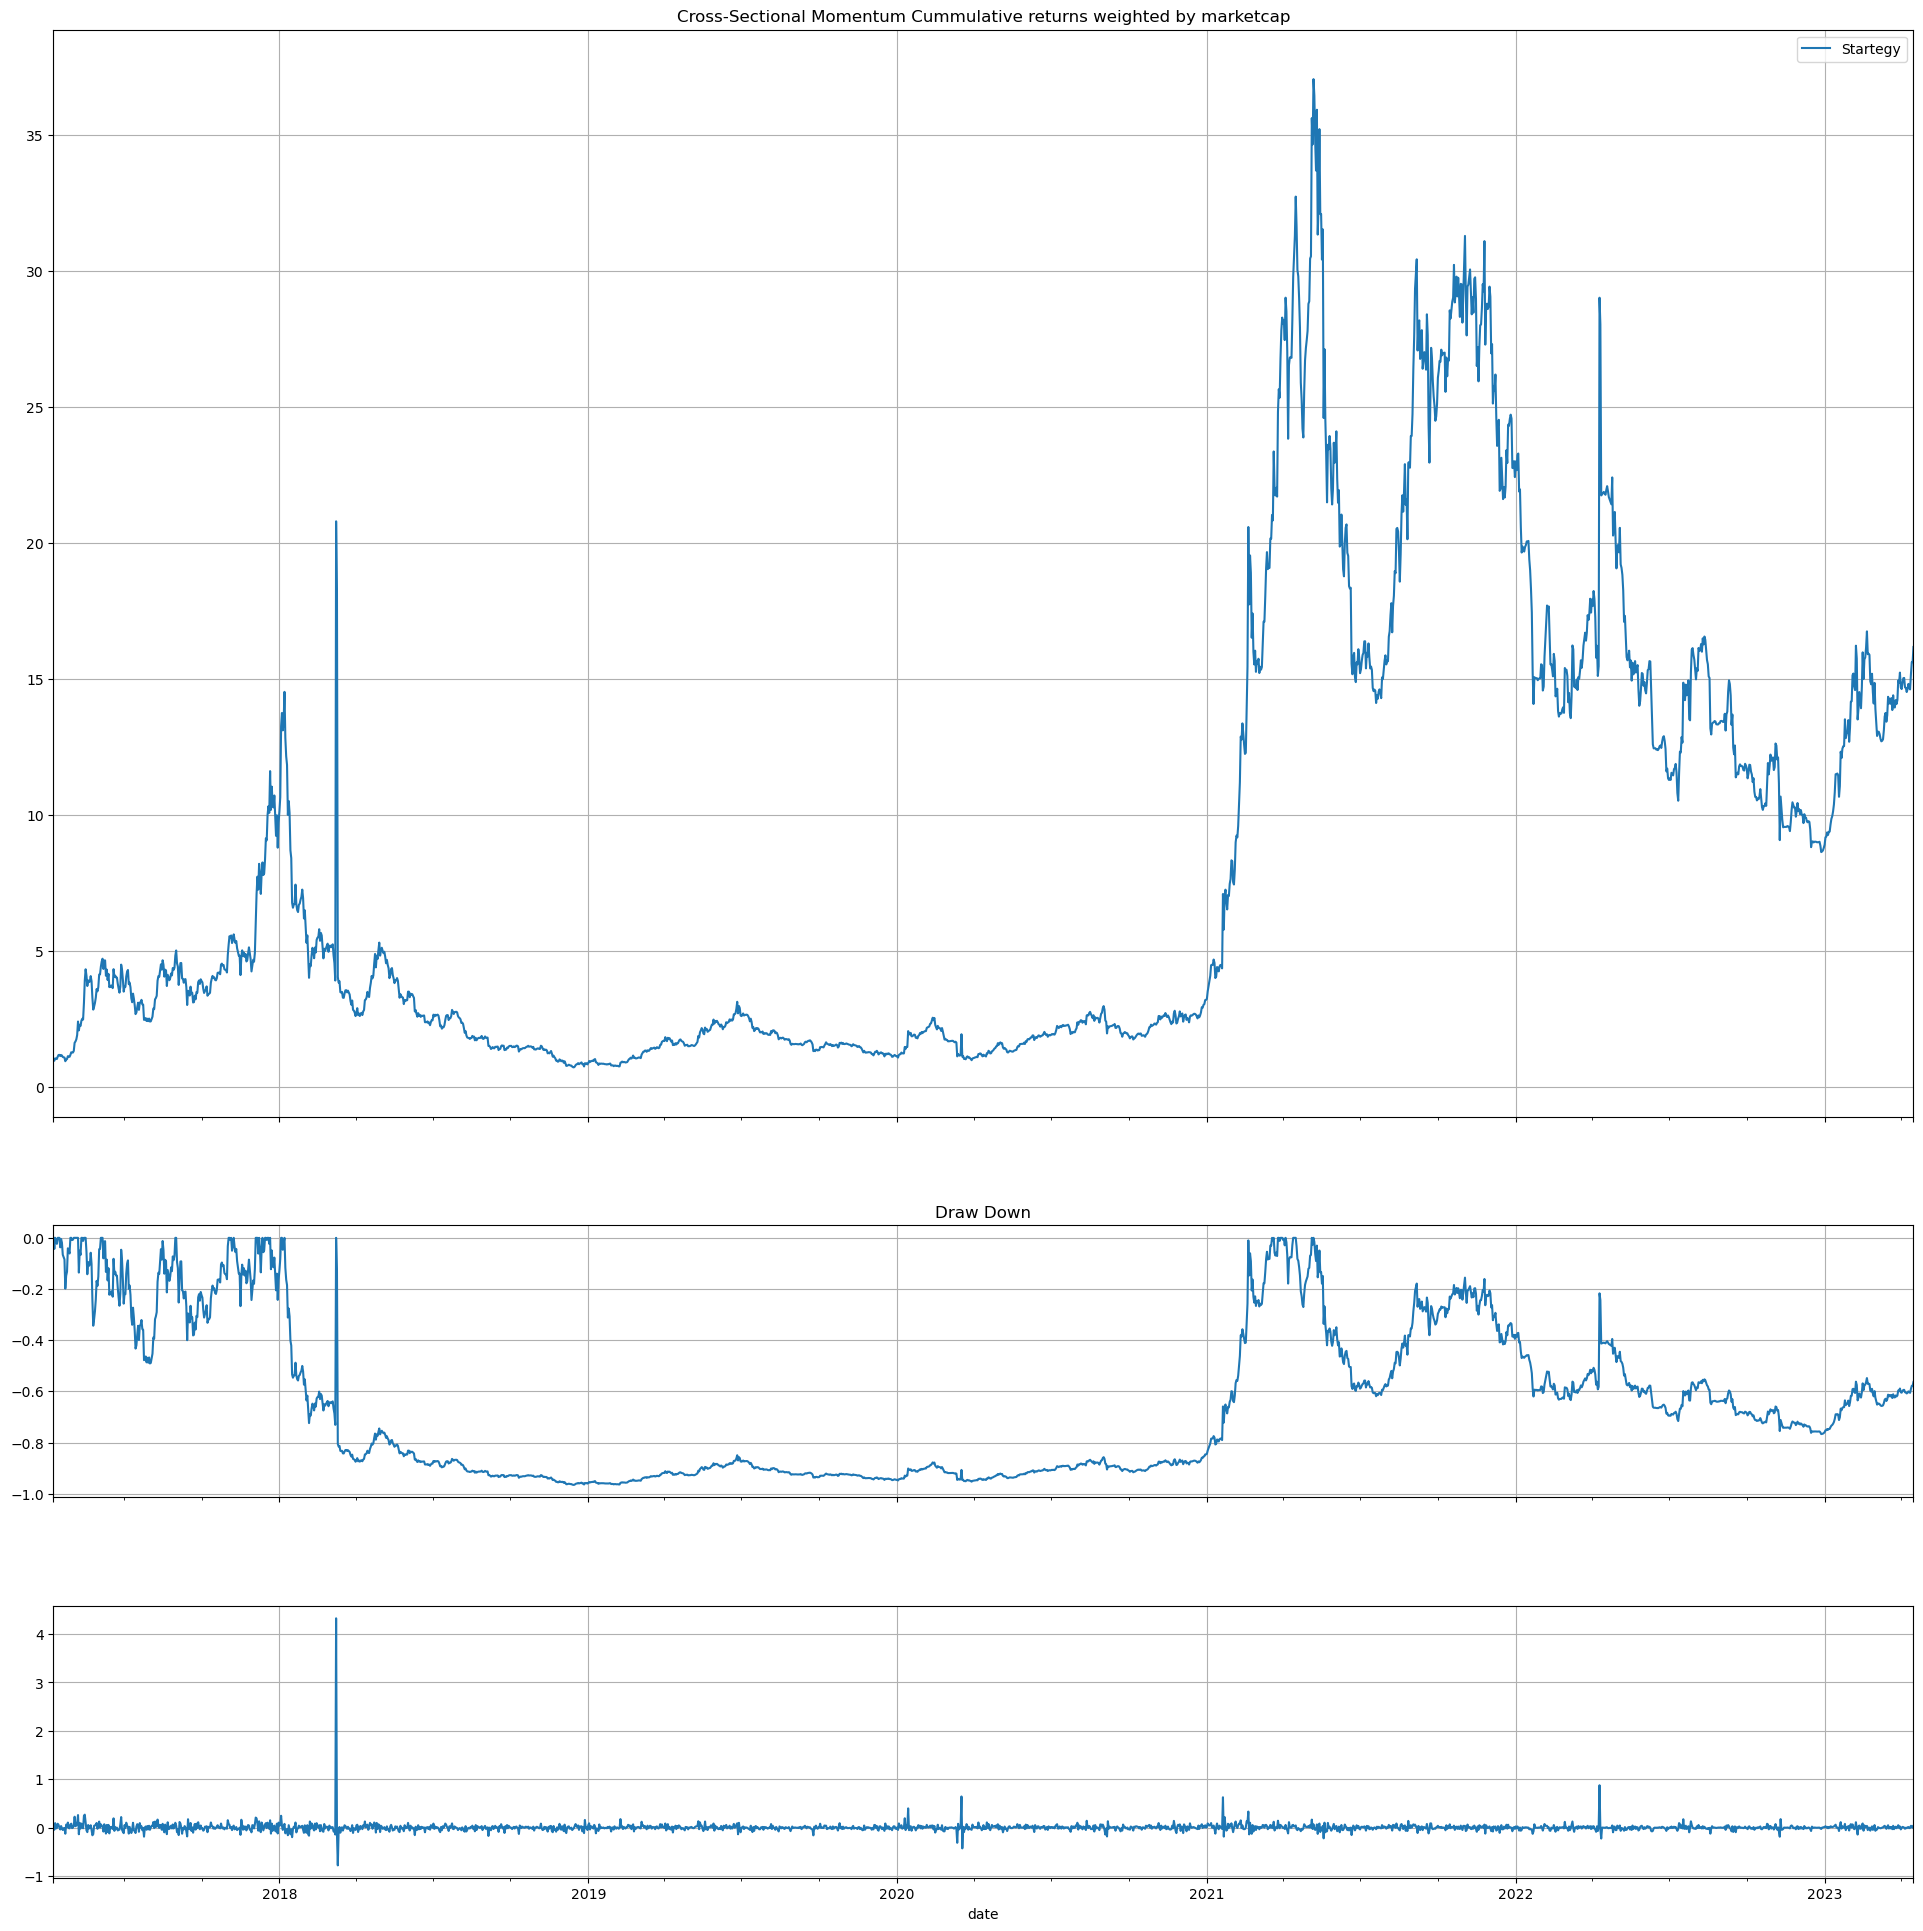

In [17]:
mytool.draw_return_result(rtn_dict, with_mkt=False)

In [18]:
mytool.print_statistics(rtn_dict, mkt_rtn=None)

,0,1,2,3,4
CAGR,22.215579,-14.616491,84.328039,169.917922,58.732202
Mean,51.390152,0.299603,0.995991,1.418262,1.617548
STD,105.574097,0.948163,0.875526,0.933384,2.113023
Shape,0.486769,0.315982,1.137592,1.519484,0.765514
